參考文件
1. Yoo, Jae-Chern, and Tae Hee Han. "Fast normalized cross-correlation." Circuits, systems and signal processing 28.6 (2009): 819-843.

In [217]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
import queue
from scipy.signal import convolve2d, correlate2d

In [218]:
img = cv2.imread('./source/Die1.tif')
template = cv2.imread('./template/Die-Template.tif')

In [219]:
img_gray = img[:, :, 2]*0.299 + img[:, :, 1]*0.587 + img[:, :, 0]*0.114
img_gray = img_gray.astype(np.float32)

template_gray = template[:, :, 2]*0.299 + template[:, :, 1]*0.587 + template[:, :, 0]*0.114
template_gray = template_gray.astype(np.float32)

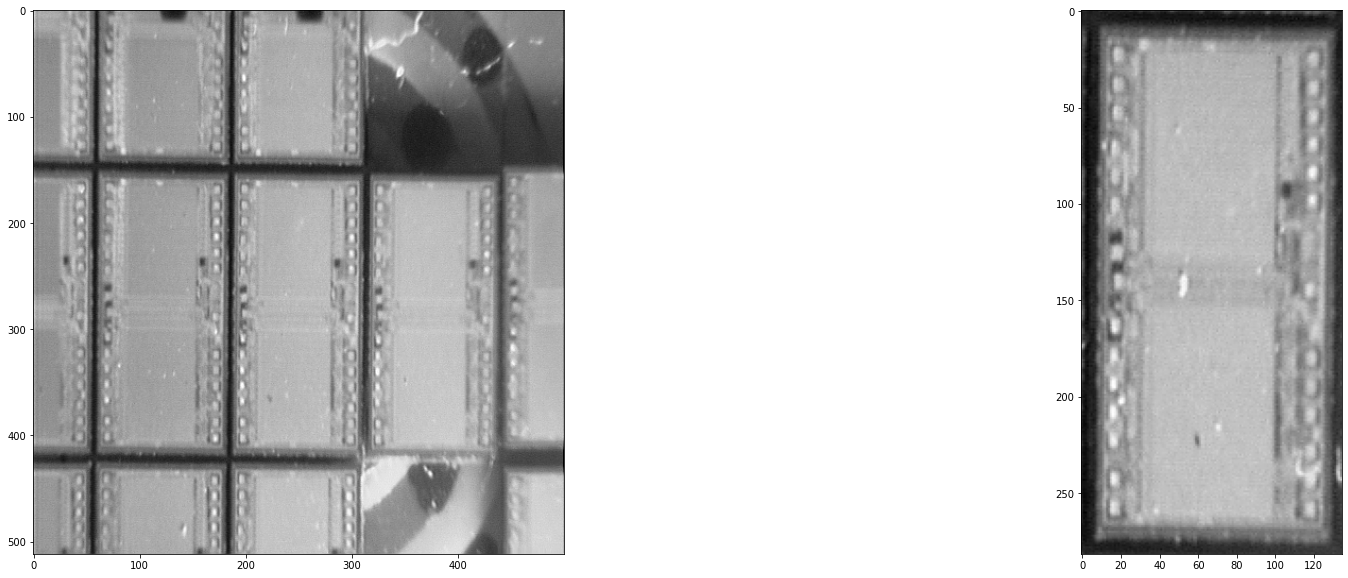

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(img_gray, cmap='gray')
ax[1].imshow(template_gray, cmap='gray')

![](img/texureMatching公式.jpg)

In [221]:
# template_gray = template_gray[::2, ::2]
# img_gray = img_gray[::2, ::2]

In [222]:
h, w = template_gray.shape
template_norm = template_gray - np.mean(template_gray)

In [223]:
# pad
# pad = np.array(template_gray.shape) // 2
# padded_img_gray = np.zeros([img_gray.shape[0] + pad[0]*2, img_gray.shape[1] + pad[1]*2], dtype=np.float32)
# padded_img_gray[pad[0]:-pad[0], pad[1]:-pad[1]] = img_gray

padded_img_gray = img_gray.copy()

# conv windows
view_shape = tuple(np.subtract(padded_img_gray.shape, template_gray.shape) + 1) + template_gray.shape
strides = padded_img_gray.strides + padded_img_gray.strides
sub_matrices = np.lib.stride_tricks.as_strided(padded_img_gray, view_shape, strides)

In [224]:
# R = np.zeros([*sub_matrices.shape[:2]])
# for i, j in itertools.product(range(sub_matrices.shape[0]), range(sub_matrices.shape[1])):
#     img_norm = sub_matrices[i, j] - np.mean(sub_matrices[i, j])
    
#     R[i, j] = np.sum(template_norm * img_norm) / np.sqrt(np.sum(template_norm**2) * np.sum(img_norm**2))  

In [225]:
# plt.figure(figsize=(20, 20))
# plt.imshow(R)

In [226]:
m = np.einsum('ij,klij->kl', template_norm, sub_matrices)
n = np.einsum('klij->kl', sub_matrices) / (w*h) * np.sum(template_norm)

I_mean = np.einsum('klij->kl', sub_matrices) / (w*h)

b = np.sum(template_norm**2) * \
    (np.einsum('klij,klij->kl', sub_matrices, sub_matrices) - 2 * np.einsum('klij->kl', sub_matrices) * I_mean + (w*h)*I_mean**2)

b = np.sqrt(b)

r = (m - n) / b

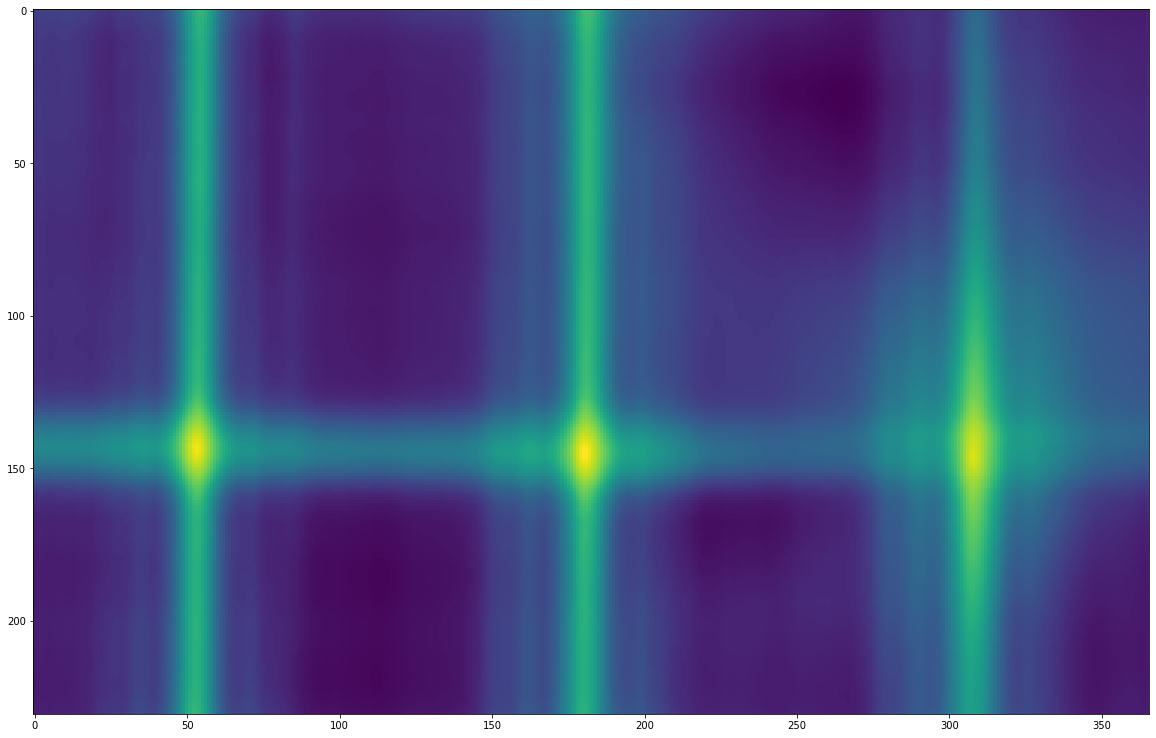

In [227]:
plt.figure(figsize=(20, 20))
plt.imshow(r)

# subsample

In [325]:
sample_imgs = [img_gray]
sample_templates = [template_gray]

for _ in range(3):
    sample_imgs.append(sample_imgs[-1][::2, ::2])
    sample_templates.append(sample_templates[-1][::2, ::2])

In [326]:
init_level = len(sample_imgs) - 1

que = queue.Queue()
# [init_level], [start_point], [w], [h]
que.put([init_level, np.array([0, 0]), sample_imgs[-1].shape[1], sample_imgs[-1].shape[0]])

In [327]:
results_loc = []
results_sim = []

In [328]:
while not que.empty():
    now_level, start_point, subimage_w, subimage_h = que.get()  
    
    now_template = sample_templates[now_level]
    now_img = sample_imgs[now_level]

    h_upper = start_point[0] - 10
    h_lower = start_point[0] + subimage_h + 10
    w_upper = start_point[1] - 10
    w_lower = start_point[1] + subimage_w + 10

    if h_upper < 0:
        h_upper = 0
    if h_lower >= now_img.shape[0]:
        h_lower = now_img.shape[0]
    if w_upper < 0:
        w_upper = 0
    if w_lower >= now_img.shape[1]:
        w_lower = now_img.shape[1]

    cut_img = now_img[h_upper:h_lower, w_upper:w_lower]
   

    # pad
    if (now_template.shape[0] >= cut_img.shape[0]) or (now_template.shape[1] >= cut_img.shape[1]):
        pad = np.array([now_template.shape[0] - cut_img.shape[0], now_template.shape[1] - cut_img.shape[1]], dtype=np.int32) //2 
    
        pad[pad >= 0] += 4
        pad[pad < 0] = 0
    
        padded_img_gray = np.pad(cut_img, [[pad[0], pad[0]], [pad[1], pad[1]]])
    else:
        padded_img_gray = cut_img


    # change view for conv
    view_shape = tuple(np.subtract(padded_img_gray.shape, now_template.shape) + 1) + now_template.shape
    strides = padded_img_gray.strides + padded_img_gray.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_img_gray, view_shape, strides)


    #
    template_h, template_w = now_template.shape
    T_norm = now_template - np.mean(now_template)  
    I_norm_mean = np.einsum('klij->kl', sub_matrices) / (template_w*template_h)

    #
    m = np.einsum('ij,klij->kl', T_norm, sub_matrices)
    n = I_norm_mean * np.sum(T_norm)

    
    T_norm_sum = np.sum(T_norm**2)
    
    I_norm_sum = np.einsum('klij,klij->kl', sub_matrices, sub_matrices) \
                    - 2 * np.einsum('klij->kl', sub_matrices) * I_norm_mean \
                    + (template_w*template_h) * I_norm_mean**2

    R = (m - n) / np.sqrt(T_norm_sum * I_norm_sum)
    
    #     
    if now_level == len(sample_imgs) - 1:
        loc = np.where( R >= 0.6)
    else:
        loc = np.where( R >= R.max())
   
    points_loc = np.array([[i, j] for i, j in zip(*loc)])
    points_sim = np.array([R[i, j] for i, j in zip(*loc)])

    targetPoint = [] 
    while len(points_loc) > 0:    
        p = points_loc[0]        

        distance = np.sqrt(np.sum((points_loc - p)**2, axis=1))
        nearPoint = np.argwhere(distance < sample_imgs[now_level].shape[1]*0.2).flatten()

        sim_argmax = np.argmax(points_sim[nearPoint])
        targetPoint.append(points_loc[nearPoint][sim_argmax])      

        points_loc = np.delete(points_loc, nearPoint, axis=0)
        points_sim = np.delete(points_sim, nearPoint, axis=0) 
    targetPoint = np.array(targetPoint)
    
    
    if len(targetPoint) <= 0:       
        continue    
    #
    if now_level == 0:  
        results_loc.append((targetPoint[0] + np.array([h_upper, w_upper])))      
        results_sim.append(R[(targetPoint[0])[0], (targetPoint[0])[1]])  
        continue    
    #
    targetPoint = targetPoint + np.array([h_upper, w_upper]) + [template_h//2, template_w//2]
   
    for x, y in targetPoint:
        h_upper = x - int(now_template.shape[0]*0.5) if x - now_template.shape[0]*0.5 > 0 else 0
        w_upper = y - int(now_template.shape[1]*0.5) if y - now_template.shape[1]*0.5 > 0 else 0

        que.put([now_level-1, (np.array([h_upper, w_upper]))*2, int((now_template.shape[1])*2), int((now_template.shape[0])*2)])
    

In [329]:
results_loc

[array([146, 308], dtype=int64),
 array([143,  53], dtype=int64),
 array([145, 180], dtype=int64)]

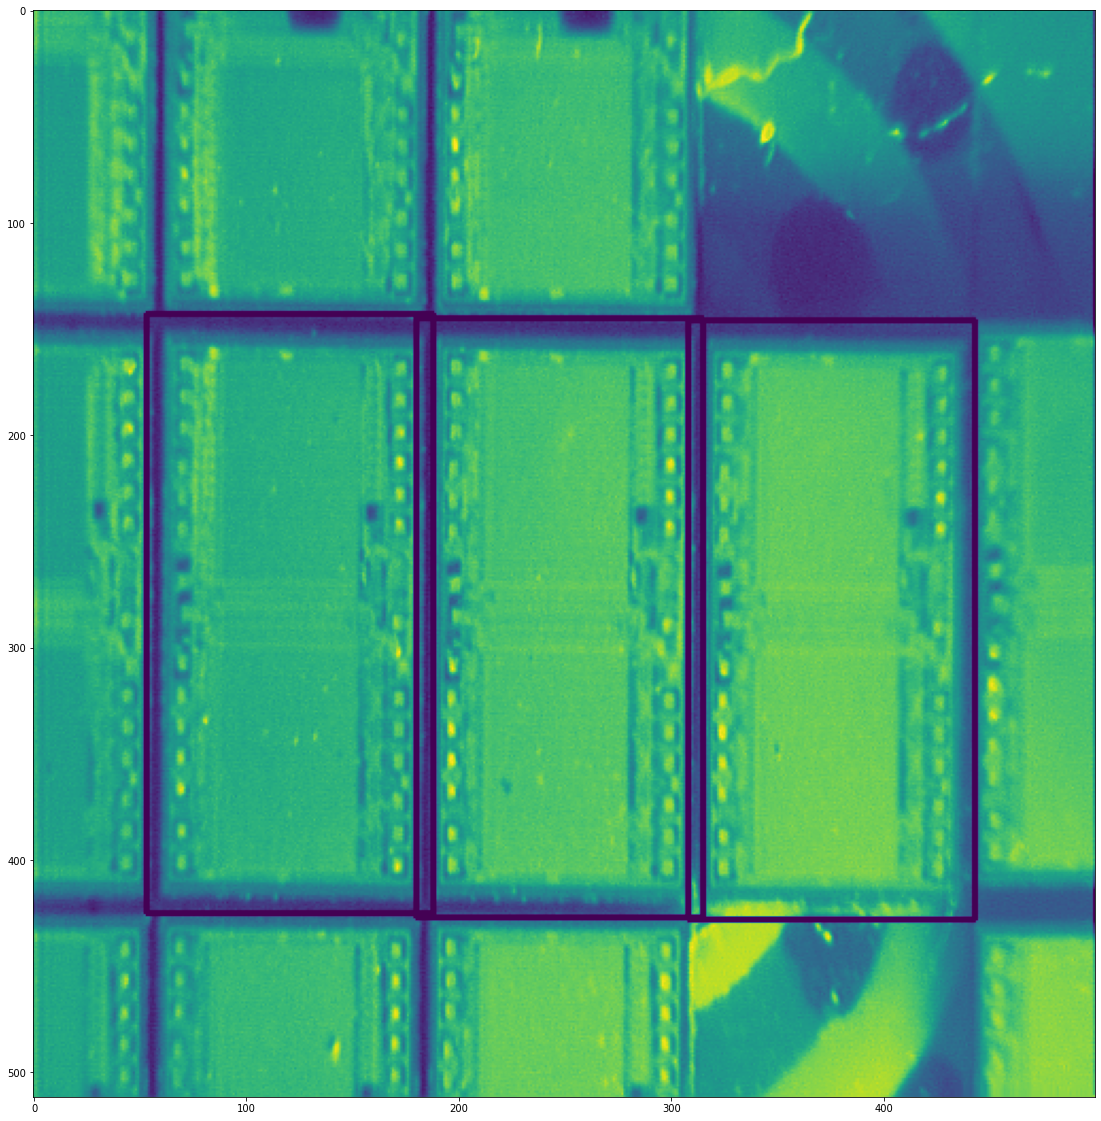

In [331]:
img_res = img_gray.copy()
w, h = template_gray.shape[::-1]

for pt in results_loc:
    cv2.rectangle(img_res, (pt[1], pt[0]), (pt[1] + w, pt[0] + h), (0, 0, 255), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img_res)

# with OpenCV

In [93]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
from scipy.signal import convolve2d, correlate2d

In [94]:
img = cv2.imread('./source/Die1.tif')
template = cv2.imread('./template/Die-Template.tif')

In [95]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [96]:
res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

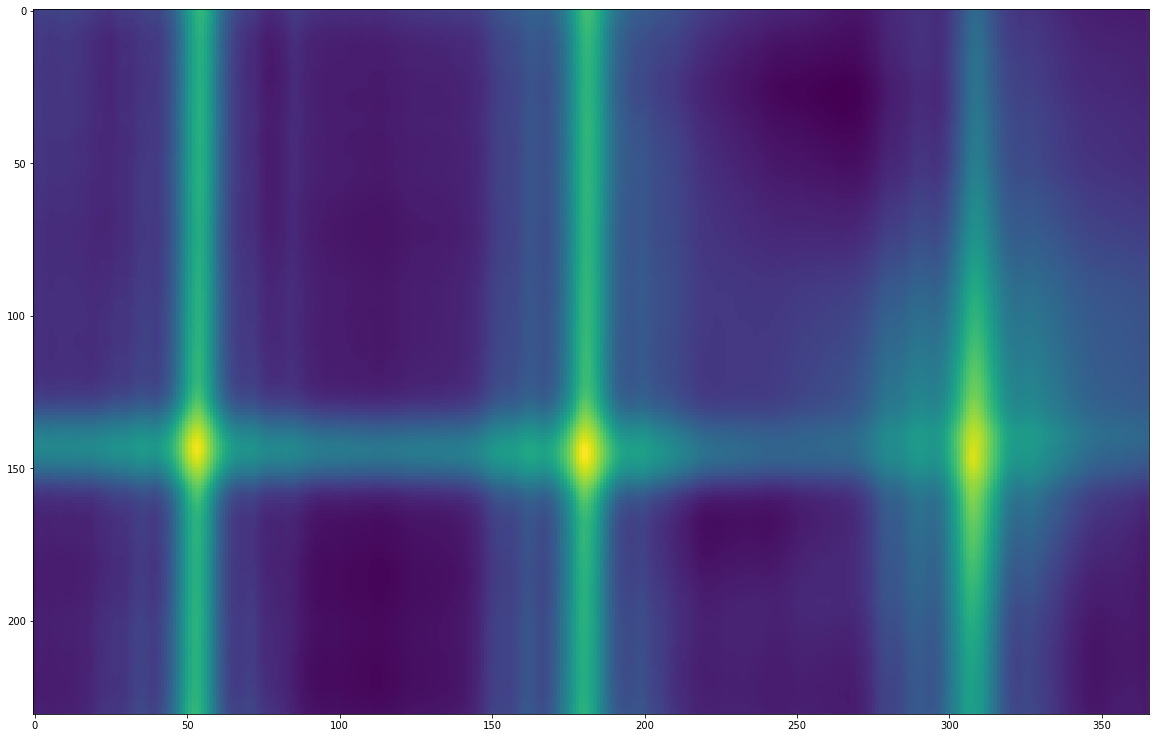

In [97]:
plt.figure(figsize=(20, 20))
plt.imshow(res)

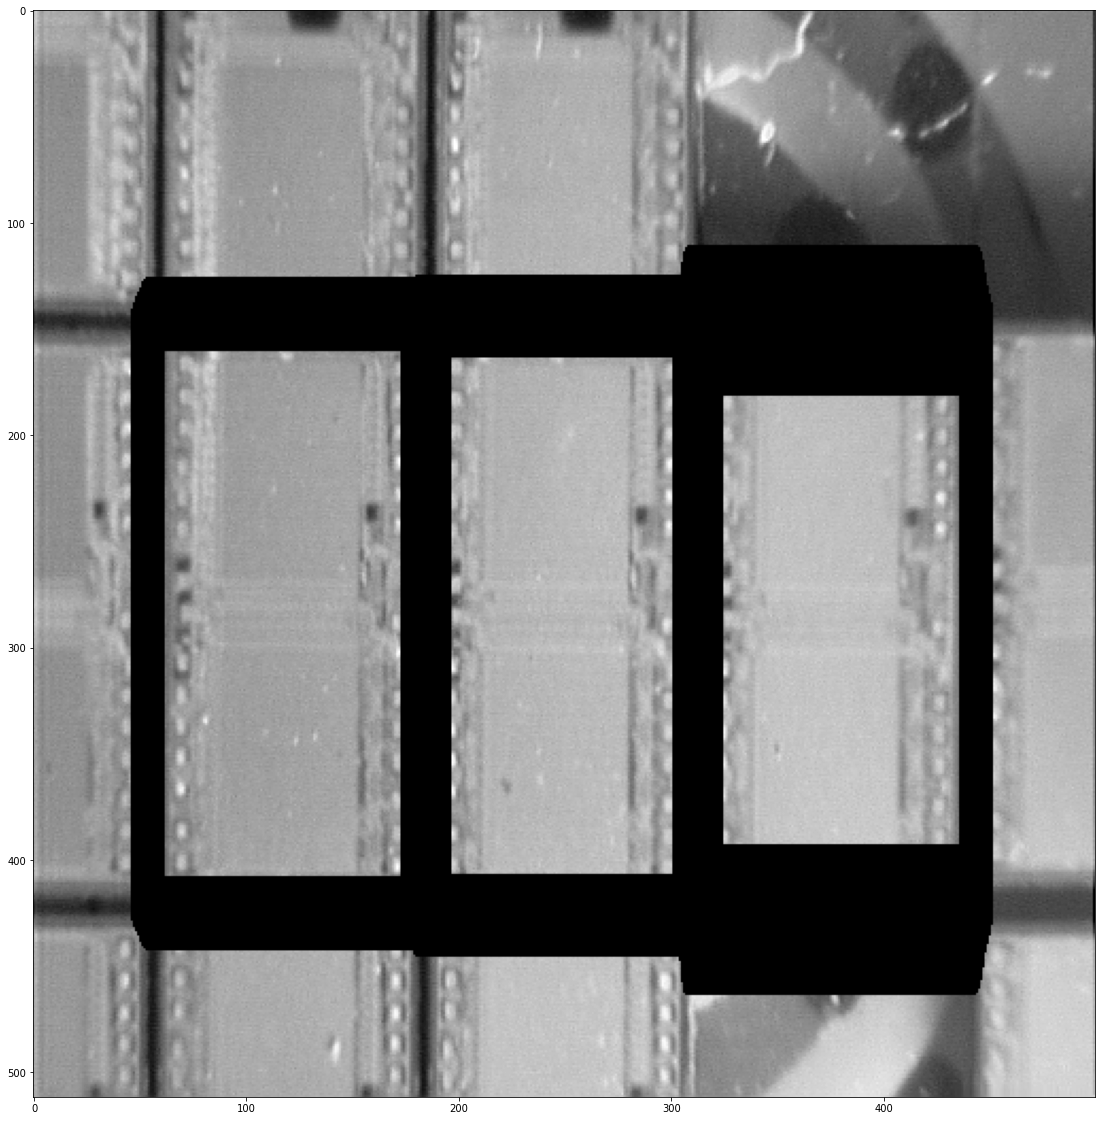

In [98]:
w, h = template_gray.shape[::-1]
img_res = img_gray.copy()

threshold = 0.6
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_res, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img_res, cmap='gray')